## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import matplotlib.image as mpimg
import pickle
import numpy as np

def undistort_img(img, mtx, dist):
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    return undistorted


def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
        sobelg = sobelx
    elif orient == 'y':
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
        sobelg = sobely
        
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobelg)
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return this mask as the binary_output image
    binary_output = sbinary
    return binary_output


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the magnitude 
    abs_sobelxy = np.sqrt(sobelx**2 + sobely**2)
    
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    
    # Create a binary mask where mag thresholds are met
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    # Return this mask as the binary_output image
    binary_output = sbinary
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output


def apply_thresholds(dst):
    
    ksize = 3
    
    #grad_binary = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100)
    #mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 100))
    #dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
    
    gradx = abs_sobel_thresh(dst, orient='x', thresh_min=20, thresh_max=100)
    grady = abs_sobel_thresh(dst, orient='y', thresh_min=20, thresh_max=100)
    mag_binary = mag_thresh(dst, sobel_kernel=3, mag_thresh=(30, 100))
    dir_binary = dir_threshold(dst, sobel_kernel=ksize, thresh=(0.7, 1.3))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    thresh = (90, 255)
    
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(dst, cv2.COLOR_RGB2HLS)
    #l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    c_binary = np.zeros_like(s_channel)
    c_binary[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    
    # Combine the binary thresholds
    combined_binary = np.zeros_like(combined)
    combined_binary[(c_binary == 1) | (combined == 1)] = 1
    
    return combined_binary
    
'''
def apply_thresholds(dst, s_thresh, sx_thresh):    
    dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(dst, cv2.COLOR_RGB2HLS)
    #l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary
'''

def image_warp(img, src, dst):
     # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image
    #warped = cv2.warpPerspective(color_binary, M, img_size)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)
    #inverse 
    Minv = cv2.getPerspectiveTransform(dst, src)
    return warped, Minv

## Computing the camera calibration, undistoring the test images, and applying color and perspective transform

/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


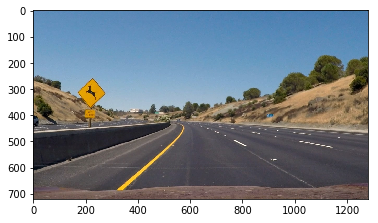

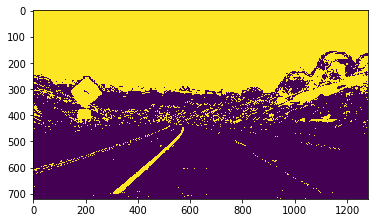

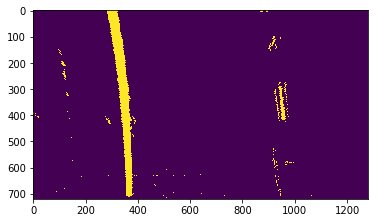

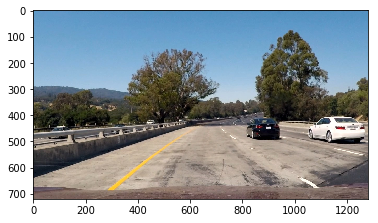

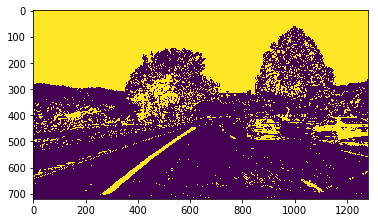

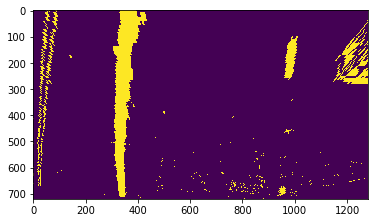

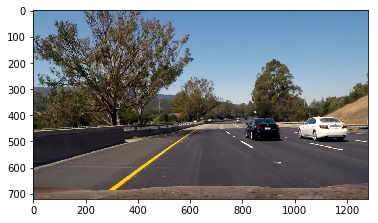

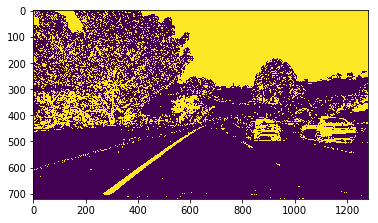

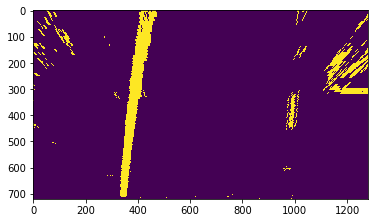

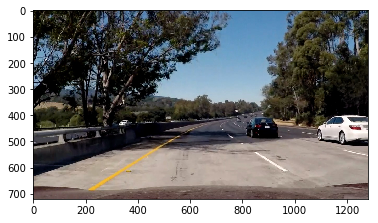

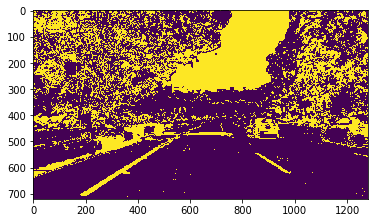

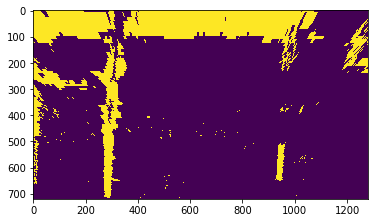

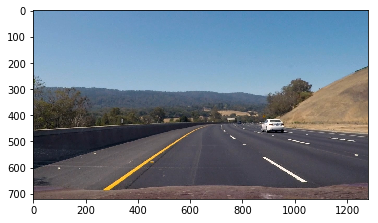

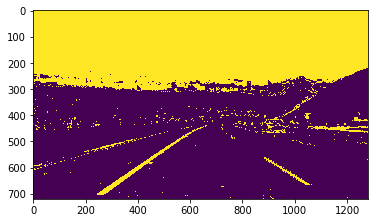

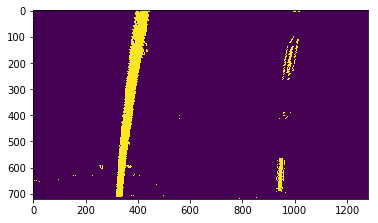

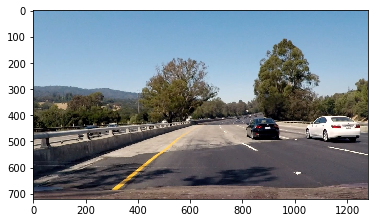

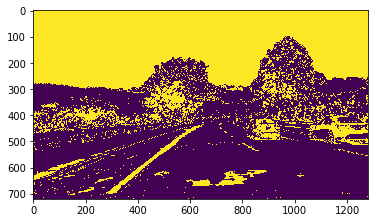

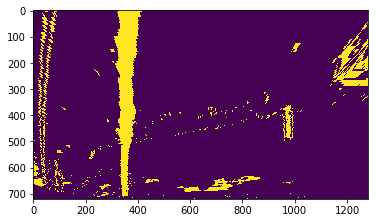

In [2]:
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt
%matplotlib inline

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
# Camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


test_images = glob.glob('./test_images/test*.jpg')
s_thresh=(150, 255) 
sx_thresh=(20, 50)
#sx_thresh=(0, 255)

warped_images = []
undistorted_images = []
Minv_images = []

src = np.float32([[720,470],[1110,720],[220,720],[570,470]])
dest = np.float32([[920,0],[920,720],[320,720],[320,0]])
#src = np.float32([[720,470],[1100,680],[270,720],[580,470]])
#dest = np.float32([[1000,0],[1000,680],[180,680],[180,0]])


path_undistorted = './output_images/undistorted_images'
#path_warped = './output_images/warped_images'
#path_binary = './output_images/binary_images'

i=1
for fname in test_images:
    img = cv2.imread(fname)
    
    # Undistorting the image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)####
    dst = undistort_img(img, mtx, dist)
    undistorted_images.append(dst)
    cv2.imwrite(os.path.join(path_undistorted , 'undist'+str(i)+'.jpg'),dst)
    #cv2.waitKey(0)
    
    #apply gradients and color transformation
    color_binary = apply_thresholds(dst)
    #cv2.imwrite(os.path.join(path_binary , 'binary'+str(i)+'.jpg'),color_binary)

    # Warp the image
    warped, Minv = image_warp(color_binary, src, dest)
    warped_images.append(warped)
    Minv_images.append(Minv)
    #cv2.imwrite(os.path.join(path_warped , 'warped'+str(i)+'.jpg'),warped)
    #cv2.waitKey(0)
    
    i+=1
    
    plt.figure(figsize=(10,10))
    fig1 = plt.figure()
    plt.imshow(img)
    #print("The undistorted images:")
    #plt.figure(figsize=(10,10))
    #fig1 = plt.figure()
    #plt.imshow(dst)
    #print("The binary images:")
    plt.figure(figsize=(10,10))
    fig2 = plt.figure()
    plt.imshow(color_binary)
    #print("----------------------------------------------------")
    #print("The warped images:")
    plt.figure(figsize=(10,10))
    fig3 = plt.figure()
    plt.imshow(warped)


## Finding lanes and determining the curvature of the lane and vehicle position with respect to center

In [3]:
def find_lanes(binary_warped):
    
    # taking a histogram along all the columns in the lower half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]/2)
    #leftx_base = np.argmax(histogram[200:midpoint])
    #rightx_base = np.argmax(histogram[midpoint:midpoint+300]) + midpoint
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # HYPERPARAMETERS
    # Number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    #window_height = np.int(binary_warped.shape[0]//nwindows)
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lanes(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    return left_fit, right_fit, ploty, out_img 


#Radius of Curvature
def radius_curvature(ploty, left_fit, right_fit):    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Define conversions in x and y from pixels space to meters
    #ym_per_pix = 30/720 # meters per pixel in y dimension
    #xm_per_pix = 3.7/700 # meters per pixel in x dimension
    ym_per_pix = 25/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/800 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curvature =  ((1 + (2*left_fit_cr[0] *y_eval*ym_per_pix + left_fit_cr[1])**2) **1.5) / np.absolute(2*left_fit_cr[0])
    right_curvature = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
    # Calculate vehicle center
    #left_lane and right lane bottom in pixels
    #left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[0]*y_eval + left_fit[2]
    #right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[0]*y_eval + right_fit[2]
    left_lane_bottom = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_lane_bottom = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    
    # Lane center as mid of left and right lane bottom                        
    lane_center = (left_lane_bottom + right_lane_bottom)/2.
    center_image = 640
    center = (lane_center - center_image)*xm_per_pix #Convert to meters
    
    #center = (((left_fit[0]*720**2+left_fit[1]*720+left_fit[2]) +(right_fit[0]*720**2+right_fit[1]*720+right_fit[2]) ) /2 - 640)*xm_per_pix
    
    
    # Now our radius of curvature is in meters
    return left_curvature, right_curvature, center

##for img in warped_images:
    ##left_fit, right_fit, ploty, out_img = fit_polynomial(img)
    ##left_curvature, right_curvature, center = radius_curvature(ploty, left_fit, right_fit)
    ##print(left_curvature, right_curvature, center)'''


## Final drawing

In [4]:
def final_draw(warped, Minv, image):
    
    left_fit, right_fit, ploty, out_img = fit_polynomial(warped)
    left_curvature, right_curvature, center = radius_curvature(ploty, left_fit, right_fit)
    #print(left_curvature, right_curvature, center)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    
    #print(color_warp.shape)
    #print(pts)
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    cv2.imwrite(os.path.join(path_final , 'final'+str(k)+'.jpg'),result)
    
    cv2.putText(result, 'Left curvature: {:.2f} m'.format(left_curvature), (50, 50), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    cv2.putText(result, 'Right curvature: {:.2f} m'.format(right_curvature), (50, 100), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    cv2.putText(result, 'Center: {:.2f}'.format(center), (50, 150), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    
    plt.figure(figsize=(10,10))
    fig = plt.figure()
    #plt.imshow(warped)
    plt.imshow(result)
    
    return result

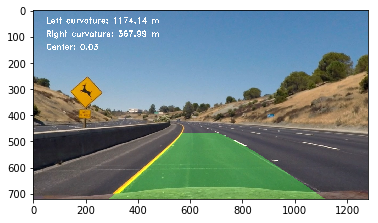

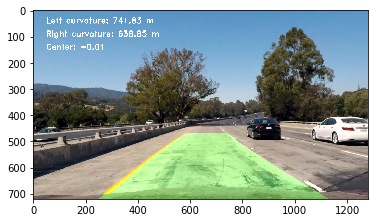

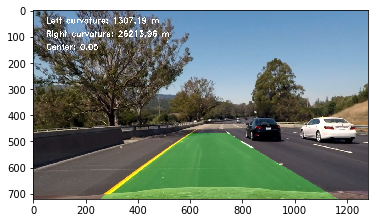

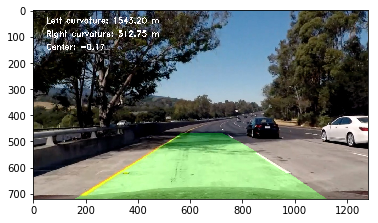

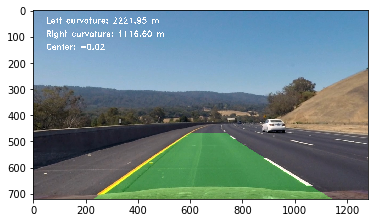

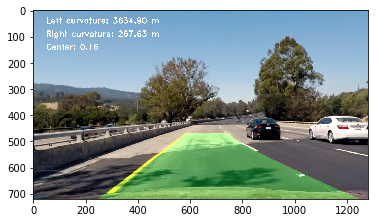

In [5]:
path_final = './output_images/final_images'

k=1
for i in range(len(warped_images)):
    final_draw(warped_images[i], Minv_images[i], undistorted_images[i])
    k+=1

## Creating Video pipeline

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def pipeline(img, show_values=False):
    
    dst = undistort_img(img, mtx, dist)
    #color_binary = apply_thresholds(dst, s_thresh, sx_thresh)
    color_binary = apply_thresholds(dst)
    warped, Minv = image_warp(color_binary, src, dest) 
    left_fit, right_fit, ploty, out_img = fit_polynomial(warped)
    left_curvature, right_curvature, center = radius_curvature(ploty, left_fit, right_fit)
    #return final_draw(out_img, Minv, img)
    return final_draw(warped, Minv, img)

def process_image(img):
    v_result = pipeline(img)
    #plt.figure(figsize=(10,10))
    #fig = plt.figure()
    #plt.imshow(v_result)
    #v_result = cv2.cvtColor(v_result, cv2.COLOR_BGR2RGB)  #####
    return v_result
    

#img = cv2.imread('./test_images/test3.jpg')
#process_image(img)

output_video = 'test_videos_output.mp4'
clip1 = VideoFileClip('./project_video.mp4')
project_clip = clip1.fl_image(process_image)
%time project_clip.write_videofile(output_video, audio=False)


[MoviePy] >>>> Building video test_videos_output.mp4
[MoviePy] Writing video test_videos_output.mp4


 88%|████████▊ | 1112/1261 [09:12<01:16,  1.95it/s]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))